<table width="100%" style="border: none; border-collapse: collapse;">
  <tr>
    <td align="center" width="55%" style="border: none;">
      <h2>Centro de Investigación en Matemáticas, A.C.</h2>
    </td>
  </tr>
</table>


<h3 align="center">Entrenamiento de modelos de aprendizaje para la clasificación de superpíxeles utilizando GridSearch</h3>

<h4 align="center">Autor: Sarahi Ventura Angoa</h4>

<p align="center">Maestría en Cómputo Estadístico - CIMAT Mty</p>
<p align="center"> Septiembre 2025</p>


<div class="alert alert-block alert-info" role="alert" style="margin-top:8px">
  <p style="margin:0 0 10px 0;">
    Este <code>notebook</code> entrena y evalúa varios modelos de aprendizaje automático para la 
    <b>clasificación multiclase</b> de superpíxeles en categorías como 
    <i>Arbol</i>, <i>Suelo Desnudo</i>, <i>Pavimento</i>, <i>Cuerpo de Agua</i>, 
    <i>Techo de Lámina</i>, <i>Techo de Losa</i>, <i>Arbusto</i>, 
    <i>Hierba y pasto seco</i>, <i>Hierba y pasto verde</i> y <i>Sombra</i>.
  </p>

  <h4 style="margin-top:10px;margin-bottom:6px;">Estrategia</h4>
  <ul style="margin-top:0;">
    <li>
      Se realiza una <b>búsqueda exhaustiva</b> de hiperparámetros mediante 
      <code>GridSearchCV</code> con <b>validación cruzada estratificada</b>, 
      usando <b>pipelines</b> para evitar fuga de información (el escalado se ajusta sólo con <code>X_train</code>).
    </li>
    <li>
      Se comparan los modelos con métricas globales y por clase; además 
      se miden y comparan <b>tiempos de entrenamiento</b> y <b>tiempos de predicción</b>.
    </li>
  </ul>

  <h4 style="margin-top:10px;margin-bottom:6px;">Modelos evaluados</h4>
  <ul style="margin-top:0;">
    <li>Vecinos más cercanos (K-Nearest Neighbors, KNN)</li>
    <li>Regresión Logística (Logistic Regression, RL)</li>
    <li>Máquinas de Soporte Vectorial (Support Vector Machines, SVM)</li>
    <li>Random Forest (Random Forest, RF)</li>
    <li>Red neuronal tipo MLP en <code>PyTorch</code> (Multilayer Perceptron, MLP, with <i>Dropout</i>)</li>
  </ul>


  <h4 style="margin-top:10px;margin-bottom:6px;">Qué se reporta</h4>
  <ul style="margin-top:0;">
    <li><b>Mejor configuración</b> por modelo (según <code>f1_weighted</code> en CV).</li>
    <li><b>Reporte de clasificación</b> por clase y global.</li>
    <li><b>Matriz de confusión</b> </li>
    <li><b>Tiempos</b> (entrenamiento y predicción) del mejor pipeline por modelo.</li>
  </ul>

  <h4 style="margin-top:10px;margin-bottom:6px;">Gráficas generadas</h4>
  <ul style="margin-top:0;">
    <li><b>Métricas por clase</b> (F1 por clase) comparando modelos.</li>
    <li><b>Tiempos de entrenamiento</b> y <b>tiempos de predicción</b> por modelo.</li>
  </ul>

  <p style="margin-top:10px;color:#555;">
    <b>Nota:</b> el conjunto está desbalanceado; por ello se reportan métricas robustas como 
    <code>F1-weighted</code> y <code>Balanced Accuracy</code>, y se emplean técnicas como 
    <i>class weights</i> en el MLP para mitigar el desbalance.
  </p>
</div>



#
<div class="alert alert-block alert-success">
<b>Importacion de las librerias</b></div>

In [ ]:
# ── Datos, utilidades y visualización ──────────────────────────────────────────
import os, time, math                      # utilidades del sistema y cronómetro
import numpy as np                         # arreglos numéricos
import pandas as pd                        # dataframes
import matplotlib.pyplot as plt            # gráficos
import seaborn as sns                      # gráficos estadísticos


from sklearn.pipeline import Pipeline
# ── Scikit-learn: split, escala, métricas, CV y pesos de clase ────────────────
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, balanced_accuracy_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import clone

# (Opcional) GridSearch y modelos clásicos para comparar
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib                                # guardar scaler/modelos sklearn

# ── PyTorch: MLP con Dropout para tabular ─────────────────────────────────────
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader  # tabular→tensores/batches




print("Todas las bibliotecas están funcionando correctamente!")



Todas las bibliotecas están funcionando correctamente!


<h2>Rutas del conjunto de datos</h2>

<div class="alert alert-block alert-success" style="background:#e6ffed;border-left:6px solid #34d058;padding:10px 12px;border-radius:6px">
<b>Rutas de origen</b>: directorios con los archivos <i>.csv</i> etiquetados. <br>
<b>Nota</b>: cada archivo comienza con el prefijo <code>Etiquetado_</code>.
</div>


In [ ]:
# --- Rutas de carpetas que contienen los archivos .csv con datos etiquetados ---
dir_carpeta_1 = '/home/victor/Documents/Etiquetadas_solo_categorias_interes/Etiquetador_2_0/'
dir_carpeta_2 = '/home/victor/Documents/Etiquetadas_solo_categorias_interes/Etiquetador-INSP/'
dir_carpeta_3 = '/home/victor/Documents/Etiquetadas_solo_categorias_interes/etiquetadas_x51/'
dir_carpeta_4 = '/home/victor/Documents/Etiquetadas_solo_categorias_interes/etiquetadas_la_laguna/'
dir_carpeta_5 = '/home/victor/Documents/Etiquetadas_solo_categorias_interes/etiquetadas_Delicias/'

# Prefijo con el que inician los nombres de archivo .csv (p.ej., 'Etiquetado_XXXX.csv')
prefijo = 'Etiquetado_'


<h2>Lectura y unificación de CSV por carpeta</h2>

<div class="alert alert-block alert-success" style="background:#e6ffed;border-left:6px solid #34d058;padding:10px 12px;border-radius:6px">
<b>Función <code>get_data(dir_data, prefijo)</code></b><br>
Lee todos los <code>.csv</code> en una carpeta, agrega la columna <code>img_file</code> derivada del nombre del archivo, 
y devuelve:
<ul style="margin:6px 0 0 16px">
<li><b>data</b>: DataFrame completo concatenado (todas las columnas originales + <code>img_file</code>)</li>
<li><b>X</b>: DataFrame con covariables (features) [fatía por índice de columnas]</li>
<li><b>y</b>: Series con la etiqueta numérica (columna <code>categoria</code>)</li>
<li><b>y_cat</b>: lista de nombres legibles por cada fila (usando <code>ynames</code>)</li>
<li><b>ynames</b>: diccionario <code>{int: nombre_de_clase}</code></li>
<li><b>imagen</b>: Series con el nombre base del archivo (por fila)</li>
</ul>
</div>


In [30]:
def get_data(dir_data, prefijo):
    """
    Lee todos los CSV de 'dir_data', añade una columna 'img_file' 
    obtenida del nombre del archivo (quitando el 'prefijo' y la extensión),
    y construye:
      - data: DataFrame concatenado
      - X: DataFrame de covariables (features)
      - y: etiquetas numéricas (int), columna 'categoria'
      - y_cat: nombres legibles por fila (map desde ynames)
      - ynames: dict {int: nombre_de_clase}
      - imagen: Series con nombre base del archivo por fila
    """
    data = pd.DataFrame()

    # Recorremos todos los archivos de la carpeta
    for file in os.listdir(dir_data):
        # Cargamos solo CSV
        if file.endswith('.csv'):
            try:
                # Lee el CSV
                temp = pd.read_csv(os.path.join(dir_data, file))

                # img_file: nombre base del archivo sin el prefijo ni la extensión
                #   - len(prefijo): corta 'Etiquetado_' del comienzo
                #   - split('.')[0]: quita extensión
                tt = [file[len(prefijo):].split('.')[0]] * temp.shape[0]
                temp['img_file'] = tt

                # Concatenamos fila a fila
                data = pd.concat([data, temp], ignore_index=True)

            except Exception as e:
                # Si un CSV está corrupto o hay error de lectura, informamos y continuamos
                print(f"Error al cargar {file}: {e}")
        else:
            # Mensaje informativo si hay otros archivos no-CSV en la carpeta
            print(f"Archivo ignorado: {file} (no es CSV)")

    # Validación básica: si nada se cargó, avisamos
    if data.empty:
        raise ValueError("No se encontraron archivos CSV válidos.")

    # Nombre de la columna que almacena la categoria:
    cat = 'categoria'

    # Selección de covariables por posiciones:
    #   las features están desde la 3ra columna (índice 2) hasta la penúltima (índice -1)
    covariables = list(data.columns[2:data.shape[1]-1])

    # Guardamos la columna 'img_file' para devolverla aparte
    imagen = data['img_file']

    # Diccionario de mapeo etiqueta->nombre legible
    ynames = {
        0:'Arbol', 1:'Suelo Desnudo', 2:'Pavimento', 3:'Cuerpo de Agua',
        4:'Techo de Lamina', 5:'Techo de Losa', 6:'Arbusto', 7:'Hierba y pasto seco',
        8:'Hierba y pasto verde', 9:'Sombra'
    }

    # Vector de clase numérica como int (asegura tipo correcto)
    y = data[cat].astype('int')

    # Lista paralela de nombres legibles (según ynames)
    y_cat = [ynames[i] for i in y]

    # Subconjunto de columnas de features
    X = data[covariables]

    return data, X, y, y_cat, ynames, imagen


In [34]:
# datos de todas las carpetas
data1, X1, y1, y_cat1, label_encoder1, imagen1 = get_data(dir_carpeta_1, prefijo)
data2, X2, y2, y_cat2, label_encoder2, imagen2 = get_data(dir_carpeta_2, prefijo)
data3, X3, y3, y_cat3, label_encoder3, imagen3 = get_data(dir_carpeta_3, prefijo)
data4, X4, y4, y_cat4, label_encoder4, imagen4 = get_data(dir_carpeta_4, prefijo)
data5, X5, y5, y_cat5, label_encoder5, imagen5 = get_data(dir_carpeta_5, prefijo)


# data es el dataframe de todos los datos cargados de los .csv
# X son las variables predictoras o feactures
# y es el numero de la categoria 0  = arboles
# y_cat son los nombres de las categorias
# label_encoder es para asigar el número de la categoría de acuerdo a su nombre
# imagen contiene los nombres de las imágenes asociadas a cada fila del DataFrame

# unir los .csv de todas las carpetas
data = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)


X = pd.concat([X1, X2, X3, X4, X5], ignore_index=True)
y = pd.concat([y1, y2, y3, y4, y5], ignore_index=True)
y_cat = y_cat1 + y_cat2 + y_cat3 + y_cat4 + y_cat5                    # Listas concatenadas
label_encoder = {**label_encoder1, **label_encoder2, **label_encoder3, **label_encoder4, **label_encoder5}
imagen = pd.concat([imagen1, imagen2, imagen3, imagen4, imagen5], ignore_index=True)




Archivo ignorado: Etiquetado_image_x5_48.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_1005.tif (no es CSV)
Archivo ignorado: requerimentos_etiquetador.txt (no es CSV)
Archivo ignorado: Etiquetado_image_x5_738.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_569.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_17.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_26.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_490.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_1247.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_70.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_35.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_60.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_51.tif (no es CSV)
Archivo ignorado: pixeles_proporciones_por_categoria_etiquetadas_de_img_etiquetar_1.txt (no es CSV)
Archivo ignorado: Etiquetado_image_x5_76.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_65.tif (no es CSV)
Archivo ignorado: Etiquetado_image_

/tmp/ipykernel_7880/1126217603.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, temp], ignore_index=True)


Archivo ignorado: Etiquetado_image_x5_117.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_3.tif (no es CSV)
Archivo ignorado: icono.ico (no es CSV)
Archivo ignorado: Etiquetado_image_x5_4647.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_469.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_34.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_2.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_151.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_31.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_59.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_197.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_30.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_62.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_85.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_1969.tif (no es CSV)
Archivo ignorado: Etiquetado_image_x5_1713.tif (no es CSV)
Archivo ignorado: Etiquetador_2_0_mejorado.py (no es CSV)
Archivo ignorado: Etiquetado_image_x5_2

In [ ]:
# Confirmar que los datos están combinados

print("Dimensiones de los datos, todos las carpetas unidas:")
print(f"DataFrame completo: {data.shape}")
print(f"Covariables (X): {X.shape}")
print(f"Etiquetas (y): {y.shape}")
print(f"Imágenes: {len(imagen)}")

Dimensiones de los datos, todos las carpetas unidas:
DataFrame completo: (108208, 132)
Covariables (X): (108208, 129)
Etiquetas (y): (108208,)
Imágenes: 108208


<h2>Partición del conjunto de datos: Train/Test</h2>

<div class="alert alert-block alert-info" role="alert" style="margin-top:8px">
Datos en entrenamiento (70%) y prueba (30%) manteniendo la proporción de clases.<br>
<b>Estrategia:</b> <code>train_test_split</code> con <b>estratificación</b> (<code>stratify=y</code>) para respetar el desbalance original.<br>
<b>Reproducibilidad:</b> <code>random_state=0</code> fija la semilla; así los splits son siempre los mismos.<br>
El <i>escalado</i> (para KNN, RegLog, SVM, MLP) se ajustará <b>solo con X_train</b> para evitar fuga de información (data leakage).
</div>


In [ ]:
# Split estratificado: conserva la proporción de clases en train y test.
# test_size=0.30 -> 30% prueba, 70% entrenamiento
# random_state=0 -> reproducible
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=0
)


#
<div class="alert alert-block alert-success">
<b>Vecinos más cercanos (K-Nearest Neighbors, KNN)</b></div>


In [ ]:

# -------------------------------------------------------------------
# 1) Pipeline: StandardScaler -> KNN
# -------------------------------------------------------------------
pipeline_knn= Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])


# -------------------------------------------------------------------
# 2) Cuadrícula de hiperparámetros
# -------------------------------------------------------------------
param_grid_knn = [
    # Caso 1: Minkowski con p (Manhattan=1, Euclídea=2)
    {
        'knn__n_neighbors': [5, 11, 15, 21, 27, 35],
        'knn__weights': ['uniform', 'distance'],
        'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'knn__leaf_size': [30, 40],
        'knn__metric': ['minkowski'],
        'knn__p': [1, 2],
        'knn__n_jobs': [-1]   # paraleliza KNN (según versión de sklearn)
    },
    # Caso 2: métricas explícitas (sin p)
    {
        'knn__n_neighbors': [5, 11, 15, 21, 27, 35],
        'knn__weights': ['uniform', 'distance'],
        'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'knn__leaf_size': [30, 40],
        'knn__metric': ['euclidean', 'manhattan'],
        'knn__n_jobs': [-1]
    }
]

In [8]:

# -------------------------------------------------------------------
# 3) GridSearchCV 
# -------------------------------------------------------------------

grid_search = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=param_grid_knn,
    scoring='f1_weighted',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train) 



Fitting 3 folds for each of 384 candidates, totalling 1152 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid=[{'knn__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                             'brute'],
                          'knn__leaf_size': [30, 40],
                          'knn__metric': ['minkowski'], 'knn__n_jobs': [-1],
                          'knn__n_neighbors': [5, 11, 15, 21, 27, 35],
                          'knn__p': [1, 2],
                          'knn__weights': ['uniform', 'distance']},
                         {'knn__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                             'brute'],
                          'knn__leaf_size': [30, 40],
                          'knn__metric': ['euclidean', 'manhattan'],
                          'knn__n_jobs': [-1],
                          'knn__n_neighbors': [5, 11, 15, 21, 27, 35],
                          'knn__weights': ['uniform', 'distance']}],
             scoring='f1_weighted', verbose=1)


Mejores hiperparámetros (seleccionados por f1_weighted):
{'knn__algorithm': 'auto', 'knn__leaf_size': 30, 'knn__metric': 'minkowski', 'knn__n_jobs': -1, 'knn__n_neighbors': 15, 'knn__p': 2, 'knn__weights': 'distance'}
Mejor f1_weighted(CV): 0.7262
Tiempo de entrenamiento (mejor modelo): 0.1813 s

Tiempo de predicción (mejor modelo): 3.4993 s
Accuracy test: 0.7481
F1_weighted test: 0.7466
Balanced accuracy test: 0.6999

Desempeño del modelo por clase:
                      precision    recall  f1-score   support

               Arbol     0.6820    0.8219    0.7454      5957
       Suelo Desnudo     0.6281    0.7136    0.6681      3446
           Pavimento     0.6515    0.6559    0.6537      2252
      Cuerpo de Agua     0.9688    0.9568    0.9627      2593
     Techo de Lamina     0.9373    0.8820    0.9088      5797
       Techo de Loza     0.6680    0.5052    0.5753      2003
             Arbusto     0.6937    0.5156    0.5915      2025
 Hierba y pasto seco     0.7309    0.6168    0.

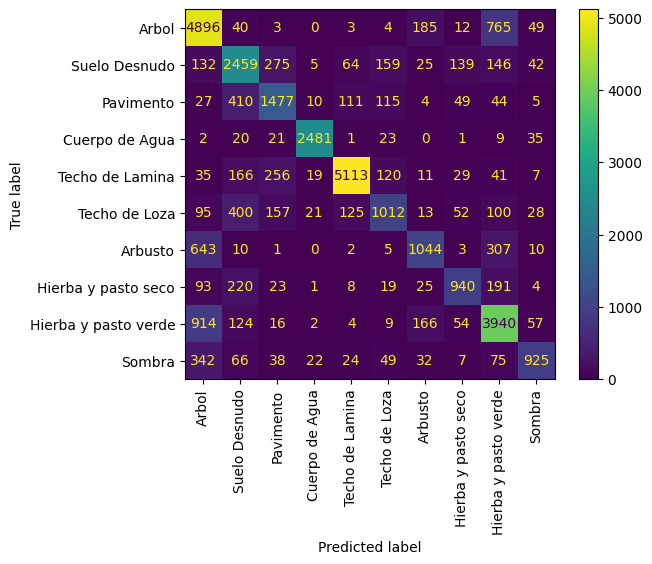

['mejor_pipeline_knn.joblib']

In [ ]:
# -------------------------------------------------------------------
# Mejores hiperparamentros encontrados
# -------------------------------------------------------------------

print("\nMejores hiperparámetros (seleccionados por f1_weighted):")
print(grid_search.best_params_)
print(f"Mejor f1_weighted(CV): {grid_search.best_score_:.4f}")


# 4) Mejor pipeline ya ajustado por GridSearch (tras refit)
mejor_pipeline_knn = grid_search.best_estimator_

# Tiempo de entrenamiento SOLO del mejor modelo
if hasattr(grid_search, "refit_time_"):
    tiempo_entrenamiento_knn = grid_search.refit_time_
else:
    # Volver a entrenar desde cero para medir el tiempo de entrenamiento
    mejor_pipeline_knn = clone(grid_search.best_estimator_)
    time_start_train_knn = time.time()
    mejor_pipeline_knn.fit(X_train, y_train)
    time_end_train_knn = time.time()
    tiempo_entrenamiento_knn = time_end_train_knn - time_start_train_knn

print(f"Tiempo de entrenamiento (mejor modelo): {tiempo_entrenamiento_knn:.4f} s")


# -------------------------------------------------------------------
# 5) Mejor modelo y evaluación en test
# -------------------------------------------------------------------
time_star_test_knn= time.time()
y_pred_knn= mejor_pipeline_knn.predict(X_test)
time_end_test_knn = time.time()
tiempo_prediccion_knn = time_end_test_knn -time_star_test_knn


print(f"\nTiempo de predicción (mejor modelo): {tiempo_prediccion_knn:.4f} s")
print(f"Accuracy test: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"F1_weighted test: {f1_score(y_test, y_pred_knn, average='weighted', zero_division=0):.4f}")

print(f"Balanced accuracy test: {balanced_accuracy_score(y_test, y_pred_knn):.4f}\n")




# =========================================================
# 6) Reporte por clases
#    Usamos tus nombres de etiquetas (ynames: dict {int: str})
# =========================================================

labels_order = sorted(ynames.keys())
target_names = [ynames[i] for i in labels_order]

print("Desempeño del modelo por clase:")
print(classification_report(
    y_test, y_pred_knn,
    labels=labels_order,
    target_names=target_names,
    digits=4,
    zero_division=0
))


# =========================================================
# 7) Matriz de confusión
# =========================================================
plt.style.use('default')

# Matriz de confusion

cm = confusion_matrix(y_test, y_pred_knn)

# visualizacion de la matriz de confusion 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(ynames.values()))
disp.plot()

plt.xticks(rotation=90)
plt.show()



# -------------------------------------------------------------------
# 7) Guardar el mejor modelo
# -------------------------------------------------------------------

joblib.dump(mejor_pipeline_knn, 'mejor_pipeline_knn.joblib')


<div class="alert alert-block alert-info">
<b> Regresión Logística (Logistic Regression, RL)</b>
</div>

In [ ]:
# -------------------------------------------------------------------
# 1) Pipeline: StandardScaler -> Regresión Logística
# -------------------------------------------------------------------
pipeline_reg_log = Pipeline([
    ('scaler_reg_log', StandardScaler()),
    ('reg_log', LogisticRegression(
        class_weight='balanced',
        random_state=42,
        tol=1e-4,
        multi_class='multinomial'  
    ))
])


# -------------------------------------------------------------------
# 2) Cuadrícula de hiperparámetros
# -------------------------------------------------------------------
param_grid_reg_log = {
    'reg_log__C': [0.01, 0.1, 1, 10],
    'reg_log__penalty': ['l2'],
    'reg_log__solver': ['lbfgs', 'saga', 'newton-cg'],
    'reg_log__max_iter': [500, 1000, 5000],
}


# -------------------------------------------------------------------
# 3) GridSearchCV
# -------------------------------------------------------------------
grid_search_reg_log = GridSearchCV(
    estimator=pipeline_reg_log,
    param_grid=param_grid_reg_log,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search_reg_log.fit(X_train, y_train)




Fitting 3 folds for each of 36 candidates, totalling 108 fits


/home/victor/Documents/prueba_modelos/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/victor/Documents/prueba_modelos/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/victor/Documents/prueba_modelos/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/victor/Documents/prueba_modelos/venv/lib/pytho

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler_reg_log', StandardScaler()),
                                       ('reg_log',
                                        LogisticRegression(class_weight='balanced',
                                                           multi_class='multinomial',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'reg_log__C': [0.01, 0.1, 1, 10],
                         'reg_log__max_iter': [500, 1000, 5000],
                         'reg_log__penalty': ['l2'],
                         'reg_log__solver': ['lbfgs', 'saga', 'newton-cg']},
             scoring='f1_weighted', verbose=1)


Mejores hiperparámetros (seleccionados por f1_weighted):
{'reg_log__C': 10, 'reg_log__max_iter': 500, 'reg_log__penalty': 'l2', 'reg_log__solver': 'newton-cg'}
Mejor f1_weighted (CV): 0.6692
Tiempo de entrenamiento (mejor modelo): 54.0928 s

Tiempo de predicción (mejor modelo): 0.0429 s
Accuracy test: 0.6687
F1_weighted test: 0.6740
Balanced accuracy test: 0.6742

Reporte de clasificación (por clase):
              precision    recall  f1-score   support

           0     0.6937    0.5620    0.6210      5957
           1     0.6570    0.4840    0.5574      3446
           2     0.5759    0.6607    0.6154      2252
           3     0.9710    0.9441    0.9574      2593
           4     0.9321    0.8542    0.8914      5797
           5     0.4686    0.6141    0.5315      2003
           6     0.2797    0.3872    0.3248      2025
           7     0.5791    0.8386    0.6851      1524
           8     0.6852    0.6215    0.6518      5286
           9     0.5446    0.7759    0.6400      1580

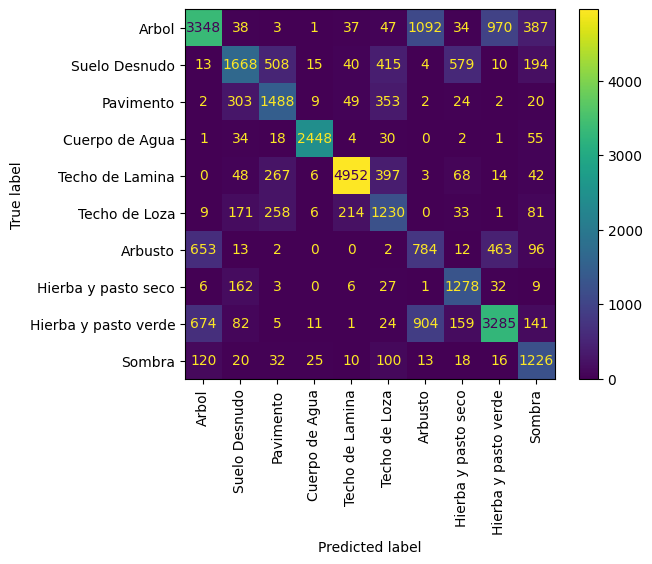

['mejor_pipeline_reg_log.joblib']

In [ ]:
# -------------------------------------------------------------------
# Mejores hiperparámetros encontrados
# -------------------------------------------------------------------
print("\nMejores hiperparámetros (seleccionados por f1_weighted):")
print(grid_search_reg_log.best_params_)
print(f"Mejor f1_weighted (CV): {grid_search_reg_log.best_score_:.4f}")

# -------------------------------------------------------------------
# 4) Mejor pipeline (refit) y tiempo de ENTRENAMIENTO SOLO del mejor
# -------------------------------------------------------------------
mejor_pipeline_reg_log = grid_search_reg_log.best_estimator_

if hasattr(grid_search_reg_log, "refit_time_"):   
    tiempo_entrenamiento_reg_log = grid_search_reg_log.refit_time_
else:
    mejor_pipeline_reg_log = clone(grid_search_reg_log.best_estimator_)
    time_start_train_reg_log = time.time()
    mejor_pipeline_reg_log.fit(X_train, y_train)
    time_end_train_reg_log = time.time()
    tiempo_entrenamiento_reg_log = time_end_train_reg_log - time_start_train_reg_log

print(f"Tiempo de entrenamiento (mejor modelo): {tiempo_entrenamiento_reg_log:.4f} s")

# -------------------------------------------------------------------
# 5) Mejor modelo y evaluación en test
# -------------------------------------------------------------------
time_star_test_reg_log = time.time()
y_pred_reg_log = mejor_pipeline_reg_log.predict(X_test)
time_end_test_reg_log = time.time()
tiempo_prediccion_reg_log = time_end_test_reg_log - time_star_test_reg_log

print(f"\nTiempo de predicción (mejor modelo): {tiempo_prediccion_reg_log:.4f} s")
print(f"Accuracy test: {accuracy_score(y_test, y_pred_reg_log):.4f}")
print(f"F1_weighted test: {f1_score(y_test, y_pred_reg_log, average='weighted', zero_division=0):.4f}")
print(f"Balanced accuracy test: {balanced_accuracy_score(y_test, y_pred_reg_log):.4f}\n")


# -------------------------------------------------------------------
# 6) Reporte por clases 
# -------------------------------------------------------------------

print("Reporte de clasificación (por clase):")
print(classification_report(y_test, y_pred_reg_log, digits=4, zero_division=0))


labels_order = sorted(ynames.keys())
target_names = [ynames[i] for i in labels_order]

print("Desempeño del modelo por clase:")
print(classification_report(
    y_test, y_pred_reg_log,
    labels=labels_order,
    target_names=target_names,
    digits=4,
    zero_division=0
))


# =========================================================
# 7) Matriz de confusión 
# =========================================================
plt.style.use('default')
cm = confusion_matrix(y_test, y_pred_reg_log)

# visualizacion de la matriz de confusion 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(ynames.values()))
disp.plot()

plt.xticks(rotation=90)
plt.show()

# -------------------------------------------------------------------
# 7) Guardar el mejor modelo
# -------------------------------------------------------------------
joblib.dump(mejor_pipeline_reg_log, 'mejor_pipeline_reg_log.joblib')



<div class="alert alert-block alert-info">
<b> Máquinas de Soporte Vectorial (Support Vector Machines, SVM)</b>
</div>

In [ ]:
# Pipeline SVM
pipeline_svm = Pipeline([
    ('scaler_svm', StandardScaler()),
    ('svm', SVC(class_weight='balanced'))  
])

# Grid de hiperparámetros

param_grid_svm = [
    # Kernel RBF
    {
        'svm__kernel': ['rbf'],
        'svm__C': [0.1, 1, 10],
        'svm__gamma': [0.001, 0.01, 0.1, 'scale'],
    },
    # Kernel POLY
    {
        'svm__kernel': ['poly'],
        'svm__C': [0.1, 1, 10],
        'svm__gamma': [0.001, 0.01, 0.1, 'scale'],
        'svm__degree': [2, 3, 4]       
    }
]

# GridSearchCV
grid_search_svm = GridSearchCV(
    pipeline_svm,
    param_grid=param_grid_svm,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
    scoring='f1_weighted',
    n_jobs=-1, 
    verbose=1
)
grid_search_svm.fit(X_train, y_train)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


/home/victor/Documents/prueba_modelos/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler_svm', StandardScaler()),
                                       ('svm', SVC(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid=[{'svm__C': [0.1, 1, 10],
                          'svm__gamma': [0.001, 0.01, 0.1, 'scale'],
                          'svm__kernel': ['rbf']},
                         {'svm__C': [0.1, 1, 10], 'svm__degree': [2, 3, 4],
                          'svm__gamma': [0.001, 0.01, 0.1, 'scale'],
                          'svm__kernel': ['poly']}],
             scoring='f1_weighted', verbose=1)


Mejores hiperparámetros SVM (seleccionados por f1_weighted):
{'svm__C': 10, 'svm__degree': 3, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}
Mejor f1_weighted (CV): 0.7810
Tiempo de entrenamiento (mejor SVM): 8698.8983 s

Tiempo de predicción (mejor SVM): 83.1084 s
Accuracy test: 0.7981
F1_weighted test: 0.7999
Balanced accuracy test: 0.7855

Desempeño del modelo por clase:
                      precision    recall  f1-score   support

               Arbol       0.77      0.75      0.76      5957
       Suelo Desnudo       0.78      0.83      0.81      3446
           Pavimento       0.74      0.76      0.75      2252
      Cuerpo de Agua       0.96      0.97      0.96      2593
     Techo de Lamina       0.95      0.92      0.94      5797
       Techo de Loza       0.73      0.74      0.73      2003
             Arbusto       0.48      0.59      0.53      2025
 Hierba y pasto seco       0.84      0.84      0.84      1524
Hierba y pasto verde       0.80      0.74      0.77      5286
      

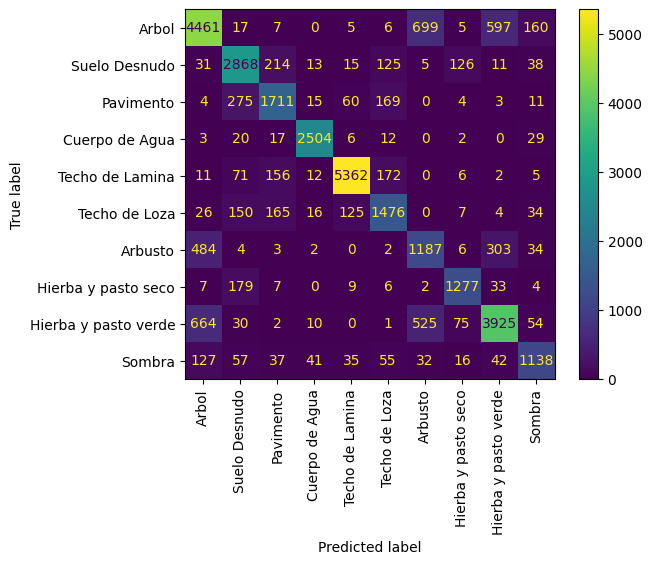

['mejor_pipeline_svm.joblib']

In [ ]:

# -------------------------------------------------------------------
# Mejores hiperparámetros encontrados
# -------------------------------------------------------------------
print("\nMejores hiperparámetros SVM (seleccionados por f1_weighted):")
print(grid_search_svm.best_params_)
print(f"Mejor f1_weighted (CV): {grid_search_svm.best_score_:.4f}")

# -------------------------------------------------------------------
# 4) Mejor pipeline (refit) y tiempo de ENTRENAMIENTO SOLO del mejor
# -------------------------------------------------------------------
mejor_pipeline_svm = grid_search_svm.best_estimator_

if hasattr(grid_search_svm, "refit_time_"):
    tiempo_entrenamiento_svm = grid_search_svm.refit_time_
else:
    mejor_pipeline_svm = clone(grid_search_svm.best_estimator_)
    time_start_train_svm = time.time()
    mejor_pipeline_svm.fit(X_train, y_train)
    time_end_train_svm = time.time() 
    tiempo_entrenamiento_svm = time_end_train_svm - time_start_train_svm

print(f"Tiempo de entrenamiento (mejor SVM): {tiempo_entrenamiento_svm:.4f} s")

# -------------------------------------------------------------------
# 5) Predicción y métricas en TEST
# -------------------------------------------------------------------
time_start_test_svm = time.time()
y_pred_svm = mejor_pipeline_svm.predict(X_test)
time_end_test_svm = time.time()
tiempo_prediccion_svm = time_end_test_svm - time_start_test_svm


print(f"\nTiempo de predicción (mejor SVM): {tiempo_prediccion_svm:.4f} s")
print(f"Accuracy test: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"F1_weighted test: {f1_score(y_test, y_pred_svm, average='weighted', zero_division=0):.4f}")
print(f"Balanced accuracy test: {balanced_accuracy_score(y_test, y_pred_svm):.4f}\n")


# =========================================================
# 6) Reporte por clases
#    Usamos tus nombres de etiquetas (ynames: dict {int: str})
# =========================================================

labels_order = sorted(ynames.keys())
target_names = [ynames[i] for i in labels_order]

print("Desempeño del modelo por clase:")
print(classification_report(
    y_test, y_pred_svm,
    labels=labels_order,
    target_names=target_names,
    digits=4,
    zero_division=0
))


# =========================================================
# 7) Matriz de confusión con etiquetas del eje X rotadas 45°
# =========================================================
plt.style.use('default')
cm = confusion_matrix(y_test, y_pred_svm, labels=labels_order)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[ynames[i] for i in labels_order])
disp.plot()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# -------------------------------------------------------------------
# 8) Guardar el mejor modelo
# -------------------------------------------------------------------
joblib.dump(mejor_pipeline_svm, 'mejor_pipeline_svm.joblib')


<div class="alert alert-block alert-info">
<b> Bosque aleatorios (Random Forest, RF)</b>
</div>

In [14]:

# -------------------------------------------------------------------
# 1) Pipeline: (Scaler) -> RandomForest
#    Los árboles no necesitan escalado. Dejamos StandardScaler en el pipeline,
#    pero en el grid probamos 'passthrough' para evitar costo innecesario.
# -------------------------------------------------------------------
pipeline_rf = Pipeline([
    ('scaler_rf', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])


# -------------------------------------------------------------------
# 2) Grid de hiperparámetros (dos dicts para evitar combinaciones inválidas)
# -------------------------------------------------------------------
param_grid_rf = [
    # Con bootstrap (permite max_samples)
    {
        'scaler_rf': ['passthrough'],        # árboles no requieren escalado
        'rf__n_estimators': [200, 400, 500,701],
        'rf__max_depth': [None, 15, 25],
        'rf__min_samples_split': [2, 5],
        'rf__min_samples_leaf': [1, 2],
        'rf__max_features': ['sqrt', 0.5],
        'rf__bootstrap': [True],
        'rf__max_samples': [None, 0.7],
        'rf__criterion': ['gini', 'entropy'],
        'rf__class_weight': ['balanced', 'balanced_subsample'],
        'rf__n_jobs': [-1],
    },
    # Sin bootstrap (no usar max_samples aquí)
    {
        'scaler_rf': ['passthrough'],
        'rf__n_estimators': [200, 400, 500, 701],
        'rf__max_depth': [None, 15, 25],
        'rf__min_samples_split': [2, 5],
        'rf__min_samples_leaf': [1, 2],
        'rf__max_features': ['sqrt', 0.5],
        'rf__bootstrap': [False],
        'rf__criterion': ['gini', 'entropy'],
        'rf__class_weight': ['balanced', 'balanced_subsample'],
        'rf__n_jobs': [-1],
    }
]

grid_search_rf_version_2 = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    scoring='f1_weighted',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
    n_jobs=-1,
    verbose=1
)

grid_search_rf_version_2.fit(X_train, y_train)

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits


/home/victor/Documents/prueba_modelos/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler_rf', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'rf__bootstrap': [True],
                          'rf__class_weight': ['balanced',
                                               'balanced_subsample'],
                          'rf__criterion': ['gini', 'entropy'],
                          'rf__max_depth': [None, 15, 25],
                          'rf__max_...
                         {'rf__bootstrap': [False],
                          'rf__class_weight': ['balanced',
                                               'balanced_subsample'],
                          'rf__criterion': ['gini', 'entropy'],
                          'rf__max_depth': [None, 15, 25],
                          'rf__max_features': ['sqrt', 0.5],
                          'rf__min_samples_leaf': [1, 2],
                          'rf__min_samples_split': [2, 5],
                          'rf__n_estimators': [200, 400, 500, 701],
                          'rf__n_jobs': [-1], 'scaler_rf': ['passthrough']}],
             scoring='f1_weighted', verbose=1)


Mejores hiperparámetros RF (seleccionados por f1_weighted):
{'rf__bootstrap': False, 'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': None, 'rf__max_features': 0.5, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 701, 'rf__n_jobs': -1, 'scaler_rf': 'passthrough'}
Mejor f1_weighted (CV): 0.8404
Tiempo de entrenamiento (mejor RF): 1334.2960 s

Tiempo de predicción (mejor RF): 1.0463 s
Accuracy test: 0.8564
F1_weighted test: 0.8546
Balanced accuracy test: 0.8316

Desempeño del modelo por clase (RF):
                      precision    recall  f1-score   support

               Arbol     0.7837    0.8848    0.8312      5957
       Suelo Desnudo     0.8400    0.8622    0.8509      3446
           Pavimento     0.8115    0.7993    0.8054      2252
      Cuerpo de Agua     0.9895    0.9780    0.9837      2593
     Techo de Lamina     0.9596    0.9589    0.9593      5797
       Techo de Loza     0.7630    0.7938    0.7781      2003
       

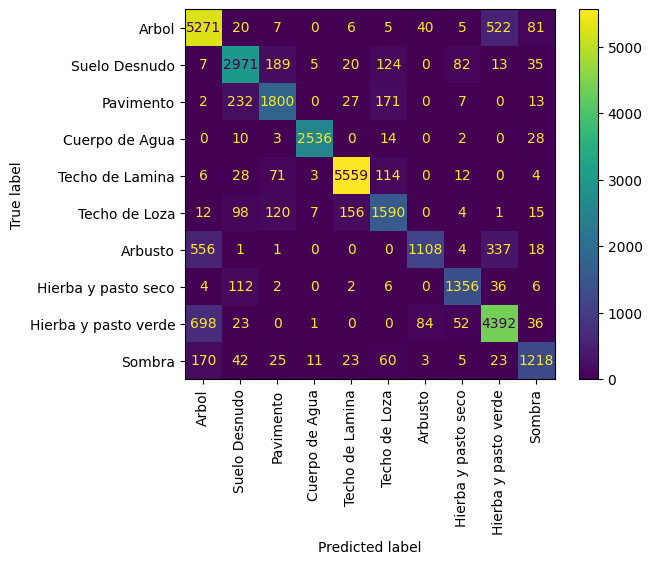

['mejor_pipeline_rf_sin_escalar.joblib']

In [ ]:

# -------------------------------------------------------------------
# Mejores hiperparámetros encontrados
# -------------------------------------------------------------------
print("\nMejores hiperparámetros RF (seleccionados por f1_weighted):")
print(grid_search_rf_version_2.best_params_)
print(f"Mejor f1_weighted (CV): {grid_search_rf_version_2.best_score_:.4f}")

# -------------------------------------------------------------------
# 4) Mejor pipeline (refit) y tiempo de ENTRENAMIENTO SOLO del mejor
# -------------------------------------------------------------------
mejor_pipeline_rf_version_2 = grid_search_rf_version_2.best_estimator_

if hasattr(grid_search_rf_version_2, "refit_time_"):
    tiempo_entrenamiento_rf_version_2 = grid_search_rf_version_2.refit_time_
else:
    mejor_pipeline_rf_version_2= clone(grid_search_rf_version_2.best_estimator_)
    time_start_train_rf_version_2= time.time()
    mejor_pipeline_rf_version_2.fit(X_train, y_train)
    time_end_train_rf_version_2 = time.time() 
    tiempo_entrenamiento_rf_version_2 = time_end_train_rf_version_2 - time_start_train_rf_version_2
print(f"Tiempo de entrenamiento (mejor RF): {tiempo_entrenamiento_rf_version_2:.4f} s")

# -------------------------------------------------------------------
# 5) Predicción y métricas en TEST
# -------------------------------------------------------------------
time_start_test_rf_version_2 = time.time()
y_pred_rf_version_2= mejor_pipeline_rf_version_2.predict(X_test)
time_end_test_rf_version_2 = time.time()

tiempo_prediccion_rf_version_2 =  time_end_test_rf_version_2 -time_start_test_rf_version_2


print(f"\nTiempo de predicción (mejor RF): {tiempo_prediccion_rf_version_2:.4f} s")
print(f"Accuracy test: {accuracy_score(y_test, y_pred_rf_version_2):.4f}")
print(f"F1_weighted test: {f1_score(y_test, y_pred_rf_version_2, average='weighted', zero_division=0):.4f}")
print(f"Balanced accuracy test: {balanced_accuracy_score(y_test, y_pred_rf_version_2):.4f}\n")


# -------------------------------------------------------------------
# 6) Reporte por clases 
# -------------------------------------------------------------------
labels_order = sorted(ynames.keys())
target_names = [ynames[i] for i in labels_order]

print("Desempeño del modelo por clase (RF):")
print(classification_report(
    y_test, y_pred_rf_version_2,
    labels=labels_order,
    target_names=target_names,
    digits=4,
    zero_division=0
))



# =========================================================
# 7) Matriz de confusión 
# =========================================================
plt.style.use('default')

cm = confusion_matrix(y_test, y_pred_rf_version_2)

# visualizacion de la matriz de confusion 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(ynames.values()))
disp.plot()

plt.xticks(rotation=90)
plt.show()


# -------------------------------------------------------------------
# 8) Guardar el mejor modelo
# -------------------------------------------------------------------
import joblib
joblib.dump(mejor_pipeline_rf_version_2, 'mejor_pipeline_rf_sin_escalar.joblib')

<div class="alert alert-block alert-info">
<b> Importancia de características (Feature importance)</b>
</div>


Top 20 variables más importantes (RF):
                    feature  importance
2                   media_b    0.218619
0                   media_r    0.167233
1                   media_g    0.114844
93   homogeneity_dist1_ang0    0.037311
98   homogeneity_dist2_ang1    0.028910
108  homogeneity_dist4_ang3    0.024842
92   homogeneity_dist0_ang3    0.020259
91   homogeneity_dist0_ang2    0.015301
90   homogeneity_dist0_ang1    0.012565
95   homogeneity_dist1_ang2    0.012158
94   homogeneity_dist1_ang1    0.011204
89   homogeneity_dist0_ang0    0.010370
5                     std_b    0.010298
107  homogeneity_dist4_ang2    0.009850
3                     std_r    0.009467
4                     std_g    0.009363
97   homogeneity_dist2_ang0    0.009134
106  homogeneity_dist4_ang1    0.007891
7                    std_mg    0.007051
103  homogeneity_dist3_ang2    0.006286


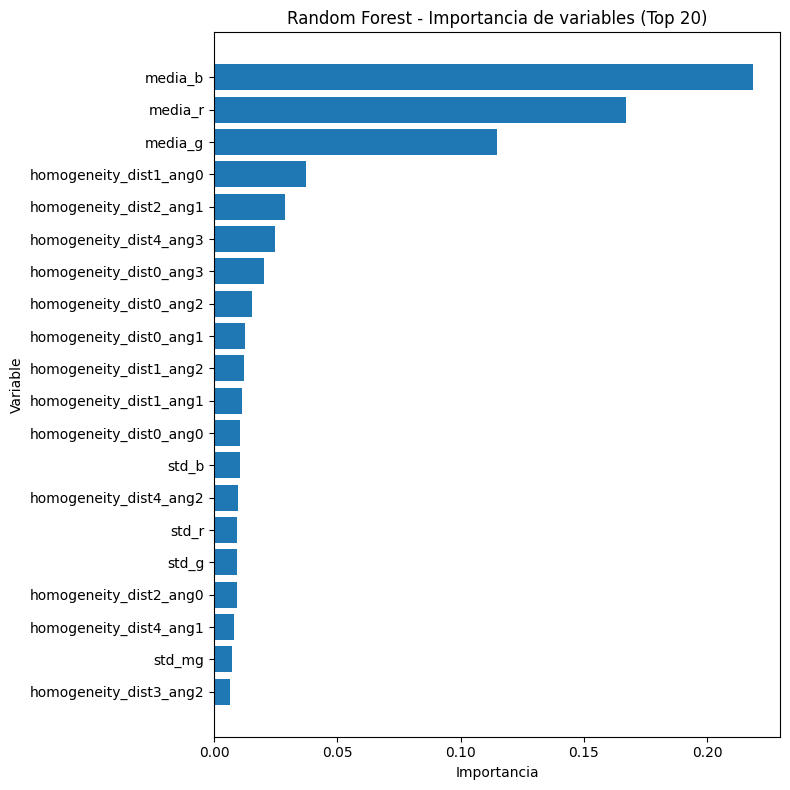

In [17]:

# -------------------------------------------------------------------
# 7) Interpretación: Feature Importances
# -------------------------------------------------------------------
rf_mejor = mejor_pipeline_rf_version_2.named_steps['rf']
importancias = rf_mejor.feature_importances_
fi_df = pd.DataFrame({'feature': X_train.columns, 'importance': importancias})
fi_df = fi_df.sort_values('importance', ascending=False)

print("\nTop 20 variables más importantes (RF):")
print(fi_df.head(20))

# (Opcional) gráfico de barras (Top 20)
topN = 20
fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(fi_df['feature'].head(topN)[::-1], fi_df['importance'].head(topN)[::-1])
ax.set_title('Random Forest - Importancia de variables (Top 20)')
ax.set_xlabel('Importancia')
ax.set_ylabel('Variable')
plt.tight_layout()
plt.show()

# (Opcional) guarda importancias a CSV
fi_df.to_csv('importancias_rf.csv', index=False)

<div class="alert alert-block alert-info">
<b> Red neuronal tipo MLP en <code>PyTorch</code> (Multilayer Perceptron, MLP, with <i>Dropout</i>)</b>
</div>

In [13]:
# Usaremos CPU (en tu máquina actual es lo correcto).
DEVICE = torch.device("cpu")

# ------------------------------------------------------------
# MLP: una red densa para datos TABULARES con Dropout
# - in_features: columnas de X (número de características)
# - n_classes:   número de clases de salida
# - hidden:      tupla con tamaños de capas ocultas (p.ej., (256,128))
# - p:           probabilidad de Dropout (regularización para evitar overfitting)
# La salida son "logits" (sin softmax); CrossEntropyLoss ya aplica softmax internamente.
# ------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, in_features, n_classes, hidden=(256,128), p=0.5):
        super().__init__()
        capas, prev = [], in_features
        for h in hidden:
            capas += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(p)]
            prev = h
        capas += [nn.Linear(prev, n_classes)]
        self.net = nn.Sequential(*capas)

    def forward(self, x):
        return self.net(x)  # logits

# ------------------------------------------------------------
# run_epoch: ejecuta UNA época completa sobre un DataLoader
# - train=True: hace forward + backward + step (entrenamiento)
# - train=False: solo forward (evaluación)
# Devuelve:
#   * pérdida promedio
#   * accuracy
#   * f1_weighted (para tener una métrica robusta si hay desbalance)
# ------------------------------------------------------------
def run_epoch(model, loader, opt, loss_fn, train=True, device=DEVICE):
    model.train() if train else model.eval()

    total, loss_sum = 0, 0.0
    y_true, y_pred = [], []

    # torch.set_grad_enabled: activa/desactiva gradientes según train/eval
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)

            if train:
                opt.zero_grad()               # limpiar gradientes acumulados

            logits = model(xb)                # forward
            loss   = loss_fn(logits, yb)      # pérdida (CrossEntropy)

            if train:
                loss.backward()               # backprop
                opt.step()                    # actualiza pesos

            # Acumulamos para métricas agregadas
            loss_sum += loss.item() * xb.size(0)
            total    += xb.size(0)
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(logits.argmax(1).detach().cpu().numpy())

    # Promedio de pérdida y métricas por época
    avg_loss = loss_sum / total
    acc      = accuracy_score(y_true, y_pred)
    f1w      = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    return avg_loss, acc, f1w


In [14]:
# =====================================================================================
# Búsqueda de hiperparámetros 
# - Maneja desbalance con class weights (CrossEntropyLoss con pesos)
# - Early Stopping por pérdida de validación (corta si no mejora varias épocas)
# - Selecciona mejor config por F1_weighted promedio en CV
# =====================================================================================

# Convertimos a numpy (float32 para X; int64 para y) y llenamos posibles NaN con 0
Xtr_np = X_train.fillna(0).to_numpy(dtype=np.float32)
Xte_np = X_test.fillna(0).to_numpy(dtype=np.float32)
ytr_np = y_train.to_numpy(dtype=np.int64)
yte_np = y_test.to_numpy(dtype=np.int64)

# Dimensiones del problema
in_features = Xtr_np.shape[1]             # número de columnas de X
num_classes = int(np.unique(ytr_np).size) # número de clases (valores únicos en y_train)

# ------------------------------------------------------------
# Busqueda de hiperparametros
# ------------------------------------------------------------
from itertools import product
param_grid_mlp = [
    {
        "hidden": [(256,128), (512,256), (256,128,64), (512,256,128)],  # arquitectura
        "p":      [0.3, 0.4, 0.5],                                      # Dropout
        "batch":  [32, 64, 128],                                        # tamaño de lote
        "lr":     [1e-3, 5e-4, 3e-4],                                   # learning rate
        "wd":     [1e-5, 1e-4, 3e-4],                                   # weight decay (L2)
        "epochs": [60, 90],                                             # épocas máx (early stopping puede cortar antes)
    }
]
# Expandimos la cuadrícula a una lista de dicts de configuraciones
keys = list(param_grid_mlp[0].keys())
SEARCH = [dict(zip(keys, v)) for v in product(*(param_grid_mlp[0][k] for k in keys))]
print("Total de configuraciones:", len(SEARCH))

# CV estratificado (n_splits=3 como ejemplo razonable)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

# Variables-resultado al estilo GridSearch
best_params_    = None  # dict con hiperparámetros ganadores
best_score_     = -np.inf  # mejor f1_weighted (promedio CV)
best_estimator_ = None  # lo crearemos en la Celda 3 (refit)
cv_results_     = []    # (opcional) lista con resultados por config

# Bucle principal de la búsqueda
for i, cfg in enumerate(SEARCH, 1):
    print(f"\n=== Config {i}/{len(SEARCH)} === {cfg}")
    f1_folds = []  # aquí guardamos f1_weighted por fold para el promedio

    # Recorremos folds estratificados
    for fold, (idx_tr, idx_va) in enumerate(skf.split(Xtr_np, ytr_np), 1):
        # 1) Split del fold (índices)
        X_tr, X_va = Xtr_np[idx_tr], Xtr_np[idx_va]
        y_tr, y_va = ytr_np[idx_tr], ytr_np[idx_va]

        # 2) Escalado SOLO con train de este fold (sin fuga)
        scaler = StandardScaler().fit(X_tr)
        X_tr = scaler.transform(X_tr).astype(np.float32)
        X_va = scaler.transform(X_va).astype(np.float32)

        # 3) Tensores y DataLoaders para PyTorch
        Xtr_t, ytr_t = torch.from_numpy(X_tr), torch.from_numpy(y_tr)
        Xva_t, yva_t = torch.from_numpy(X_va), torch.from_numpy(y_va)
        tr_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=cfg["batch"], shuffle=True)
        va_loader = DataLoader(TensorDataset(Xva_t, yva_t), batch_size=cfg["batch"], shuffle=False)

        # 4) Class weights (para desbalance): calcula pesos por clase en este fold
        clases = np.unique(y_tr)
        pesos  = compute_class_weight(class_weight="balanced", classes=clases, y=y_tr)
        # Alineamos los pesos a un vector de tamaño "num_classes" (posiciones faltantes quedan en 0)
        cw = np.zeros(num_classes, dtype=np.float32)
        cw[clases] = pesos.astype(np.float32)
        loss_fn = nn.CrossEntropyLoss(weight=torch.from_numpy(cw))

        # 5) Modelo y optimizador para ESTE fold y config
        model = MLP(in_features, num_classes, hidden=cfg["hidden"], p=cfg["p"]).to(DEVICE)
        opt   = torch.optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])

        # 6) Entrenamiento con Early Stopping en pérdida de validación:
        #    - Guardamos el "mejor estado" cuando baja la val_loss
        #    - Si no mejora por 'patience' épocas, cortamos
        best_val, best_state = math.inf, None
        patience, stalled = 8, 0  # puedes subir/bajar patience
        for ep in range(1, cfg["epochs"]+1):
            # Época de entrenamiento
            tr_loss, tr_acc, tr_f1 = run_epoch(model, tr_loader, opt, loss_fn, train=True)
            # Época de validación (sin gradiente)
            va_loss, va_acc, va_f1 = run_epoch(model, va_loader, opt, loss_fn, train=False)

            # Guarda el mejor estado según val_loss (criterio común)
            if va_loss < best_val:
                best_val, stalled = va_loss, 0
                best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            else:
                stalled += 1
                if stalled >= patience:
                    break  # detiene temprano si no mejora

            # (Opcional) Ver progreso cada N épocas:
            # if ep % 10 == 0 or ep == 1:
            #     print(f"  Epoch {ep:03d} | tr_loss={tr_loss:.4f} | va_loss={va_loss:.4f} | va_f1w={va_f1:.4f}")

        # 7) Evaluación final del fold con el mejor estado guardado
        model.load_state_dict(best_state)
        model.eval()
        with torch.no_grad():
            y_hat = model(Xva_t).argmax(1).cpu().numpy()

        f1_fold = f1_score(y_va, y_hat, average="weighted", zero_division=0)
        f1_folds.append(f1_fold)
        print(f"  Fold {fold}: f1_weighted={f1_fold:.4f}")

    # 8) Promedio de f1_weighted en los *n_splits* (score de la config)
    f1_cv = float(np.mean(f1_folds))
    cv_results_.append({"params": cfg, "mean_test_f1_weighted": f1_cv})
    print(f" -> mean f1_weighted(CV) = {f1_cv:.4f}")

    # 9) Actualizamos mejor configuración si mejora el score
    if f1_cv > best_score_:
        best_score_  = f1_cv
        best_params_ = cfg.copy()

# Resultado de la búsqueda
print("\nMejores hiperparámetros (por f1_weighted CV):")
print(best_params_)
print(f"Mejor f1_weighted(CV): {best_score_:.4f}")


Total de configuraciones: 648

=== Config 1/648 === {'hidden': (256, 128), 'p': 0.3, 'batch': 32, 'lr': 0.001, 'wd': 1e-05, 'epochs': 60}
  Fold 1: f1_weighted=0.7606
  Fold 2: f1_weighted=0.7579
  Fold 3: f1_weighted=0.7654
 -> mean f1_weighted(CV) = 0.7613

=== Config 2/648 === {'hidden': (256, 128), 'p': 0.3, 'batch': 32, 'lr': 0.001, 'wd': 1e-05, 'epochs': 90}
  Fold 1: f1_weighted=0.7583
  Fold 2: f1_weighted=0.7383
  Fold 3: f1_weighted=0.7598
 -> mean f1_weighted(CV) = 0.7522

=== Config 3/648 === {'hidden': (256, 128), 'p': 0.3, 'batch': 32, 'lr': 0.001, 'wd': 0.0001, 'epochs': 60}
  Fold 1: f1_weighted=0.7546
  Fold 2: f1_weighted=0.7606
  Fold 3: f1_weighted=0.7522
 -> mean f1_weighted(CV) = 0.7558

=== Config 4/648 === {'hidden': (256, 128), 'p': 0.3, 'batch': 32, 'lr': 0.001, 'wd': 0.0001, 'epochs': 90}
  Fold 1: f1_weighted=0.7550
  Fold 2: f1_weighted=0.7554
  Fold 3: f1_weighted=0.7390
 -> mean f1_weighted(CV) = 0.7498

=== Config 5/648 === {'hidden': (256, 128), 'p': 0.

In [ ]:
# =====================================================================
# Re-entrenar (refit) el MEJOR MLP en TODO el entrenamiento
# =====================================================================

best_params_mlp = best_params_.copy()

# 1) Escalado FINAL con TODO X_train
scaler_mlp = StandardScaler().fit(Xtr_np)
Xtr_f = scaler_mlp.transform(Xtr_np).astype(np.float32)
Xte_f = scaler_mlp.transform(Xte_np).astype(np.float32)

# Tensores completos
Xtr_t, ytr_t = torch.from_numpy(Xtr_f), torch.from_numpy(ytr_np)
Xte_t        = torch.from_numpy(Xte_f)

# 2) Pesos por clase usando TODO y_train (para desbalance)
clases_all = np.unique(ytr_np)
pesos_all  = compute_class_weight(class_weight="balanced", classes=clases_all, y=ytr_np)
cw_all = np.zeros(num_classes, dtype=np.float32)
cw_all[clases_all] = pesos_all.astype(np.float32)

#  AJUSTE: pesos al device y a float32
class_weights_t = torch.from_numpy(cw_all).to(DEVICE, dtype=torch.float32)
loss_fn_all = nn.CrossEntropyLoss(weight=class_weights_t)

# 3) Creamos el mejor modelo
mejor_pipeline_mlp = MLP(
    in_features, num_classes,
    hidden=best_params_mlp["hidden"], p=best_params_mlp["p"]
).to(DEVICE)

# Optimizador con los mejores hiperparámetros
opt_best = torch.optim.Adam(
    mejor_pipeline_mlp.parameters(),
    lr=best_params_mlp["lr"], weight_decay=best_params_mlp["wd"]
)

# DataLoader de entrenamiento completo
train_loader_full = DataLoader(
    TensorDataset(Xtr_t, ytr_t),
    batch_size=best_params_mlp["batch"], shuffle=True
)

# 4) ENTRENAMIENTO (medimos TIEMPO) con early stopping simple
time_start_train_mlp = time.time()
best_tr, best_state = math.inf, None
patience, stalled = 10, 0


for ep in range(1, best_params_mlp["epochs"] + 1):
    tr_loss, tr_acc, tr_f1 = run_epoch(
        mejor_pipeline_mlp, train_loader_full, opt_best, loss_fn_all, train=True
    )
    if tr_loss < best_tr:
        best_tr, stalled = tr_loss, 0
        best_state = {k: v.cpu().clone() for k, v in mejor_pipeline_mlp.state_dict().items()}
    else:
        stalled += 1
        if stalled >= patience:
            break

time_end_train_mlp = time.time()
tiempo_entrenamiento_mlp = time_end_train_mlp - time_start_train_mlp
mejor_pipeline_mlp.load_state_dict(best_state)

print(f"Tiempo de entrenamiento (mejor modelo): {tiempo_entrenamiento_mlp:.4f} s")

# 5) PREDICCIÓN en test (medimos TIEMPO)
time_star_test_mlp = time.time()
with torch.no_grad():
    y_pred_mlp = mejor_pipeline_mlp(Xte_t).argmax(1).cpu().numpy()
time_end_test_mlp = time.time()
tiempo_prediccion_mlp = time_end_test_mlp - time_star_test_mlp
print(f"Tiempo de predicción (mejor modelo): {tiempo_prediccion_mlp:.4f} s")

# 6) GUARDADO del checkpoint
labels_order = sorted(ynames.keys())
feature_names = list(X.columns)

save_path = "mejor_mlp_pytorch.pth"

checkpoint = {
    "state_dict": mejor_pipeline_mlp.state_dict(),
    "params": best_params_mlp,      # hidden, p, batch, lr, wd, epochs
    "scaler": scaler_mlp,           # StandardScaler ya fit con X_train
    "feature_names": feature_names, # orden de columnas
    "labels_order": labels_order,   # [0,1,...]
    "ynames": ynames,               # dict {int: nombre}
    "in_features": in_features,
    "num_classes": num_classes,
}

torch.save(checkpoint, save_path)
print(f" Guardado: {save_path}")


Desempeño del modelo por clase (MLP):
                      precision    recall  f1-score   support

               Arbol     0.7505    0.6515    0.6975      5957
       Suelo Desnudo     0.8420    0.7731    0.8061      3446
           Pavimento     0.7692    0.7962    0.7825      2252
      Cuerpo de Agua     0.9897    0.9649    0.9772      2593
     Techo de Lamina     0.9590    0.9229    0.9406      5797
       Techo de Losa     0.6742    0.7923    0.7285      2003
             Arbusto     0.3467    0.5733    0.4321      2025
 Hierba y pasto seco     0.7910    0.8865    0.8360      1524
Hierba y pasto verde     0.7925    0.6591    0.7197      5286
              Sombra     0.6734    0.8025    0.7323      1580

            accuracy                         0.7714     32463
           macro avg     0.7588    0.7822    0.7652     32463
        weighted avg     0.7929    0.7714    0.7778     32463

Accuracy test (MLP): 0.7714
F1_weighted test (MLP): 0.7778
Balanced accuracy test (MLP): 0.

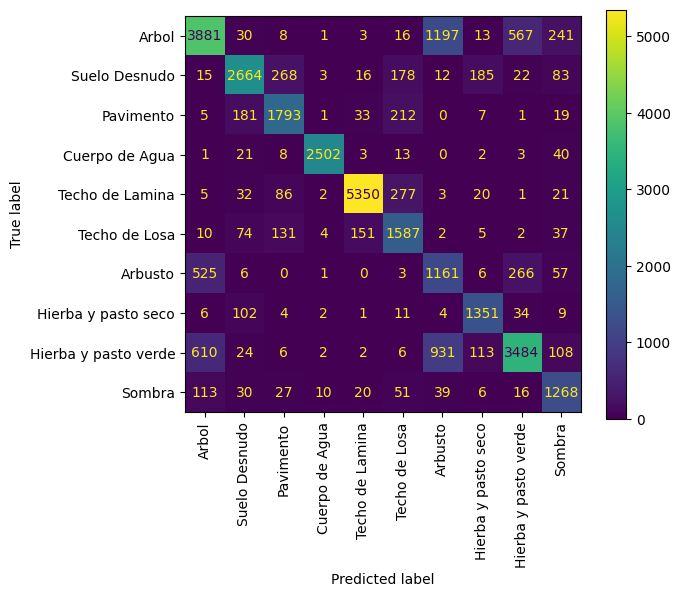

In [ ]:
# =========================================================
# 7) Reporte por clases (MLP) y métricas globales
# =========================================================
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

labels_order = sorted(ynames.keys())                 
target_names = [ynames[i] for i in labels_order]     

print("Desempeño del modelo por clase (MLP):")
print(classification_report(
    y_test, 
    y_pred_mlp, 
    labels=labels_order,
    target_names=target_names,
    digits=4,
    zero_division=0
))

print(f"Accuracy test (MLP): {accuracy_score(y_test, y_pred_mlp):.4f}")
print(f"F1_weighted test (MLP): {f1_score(y_test, y_pred_mlp, average='weighted', zero_division=0):.4f}")
print(f"Balanced accuracy test (MLP): {balanced_accuracy_score(y_test, y_pred_mlp):.4f}")

# =========================================================
# 8) Matriz de confusión
# =========================================================
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.style.use('default')
fig, ax = plt.subplots(figsize=(7, 6))

labels_order = sorted(ynames.keys())
target_names = [ynames[i] for i in labels_order]

cm = confusion_matrix(y_test, y_pred_mlp, labels=labels_order)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(ax=ax)  

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


<a id="comparacion-del-desempeno-de-los-modelos-por-clase"></a>
## 📊 Comparación del desempeño de los modelos por clase

<div class="alert alert-block alert-success">

Este bloque genera un <b>DataFrame consolidado</b> que permite comparar el desempeño de cada modelo por clase.<br><br>

Se realizó lo siguiente:

<ul> <li>Se crearon predicciones para cada modelo entrenado previamente.</li> <li>Se generó el <code>classification_report</code> para cada modelo.</li> <li>Se extrajeron las métricas <i>f1-score</i>, <i>recall</i> y <i>precision</i> por clase (0 a 9).</li> <li>Se construyó un DataFrame unificado para todas las clases y modelos, facilitando el análisis y visualización comparativa.</li> </ul> </div>

In [ ]:
# ============================================================
# COMPARACIÓN POR CLASE Y RESUMEN GLOBAL POR MODELO
# - Usa tus variables: y_pred_knn, y_pred_reg_log, y_pred_svm,
#   y_pred_rf_version_2, y_pred_mlp 
# - Grafica F1 por clase (por modelo)
# - Construye tabla resumen global (accuracy, f1_weighted, balanced acc)
# ============================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, balanced_accuracy_score, classification_report
)

# --- Empaquetamos modelos con sus predicciones (agrega MLP si existe) ---
modelos = [
    ("KNN", y_pred_knn),
    ("Regresión Logística", y_pred_reg_log),
    ("SVM", y_pred_svm),
    ("Random Forest", y_pred_rf_version_2),
    ("Redes neuronales", y_pred_mlp)
]


# --------- 1) DataFrame por clase (F1/Recall/Precision) ----------
df_por_clase = pd.DataFrame()

for nombre_modelo, y_pred in modelos:
    report = classification_report(y_test, y_pred, output_dict=True)
    df_temp = pd.DataFrame(report).T

    # Nos quedamos con filas de clases numéricas y agregamos nombres
    df_temp = df_temp[df_temp.index.str.isdigit()]
    df_temp.index = df_temp.index.astype(int)
    df_temp['Clase'] = df_temp.index.map(ynames)  # mapea 0..9 a nombre
    df_temp['Modelo'] = nombre_modelo

    df_por_clase = pd.concat([
        df_por_clase,
        df_temp[['Clase', 'Modelo', 'f1-score', 'recall', 'precision']]
    ])




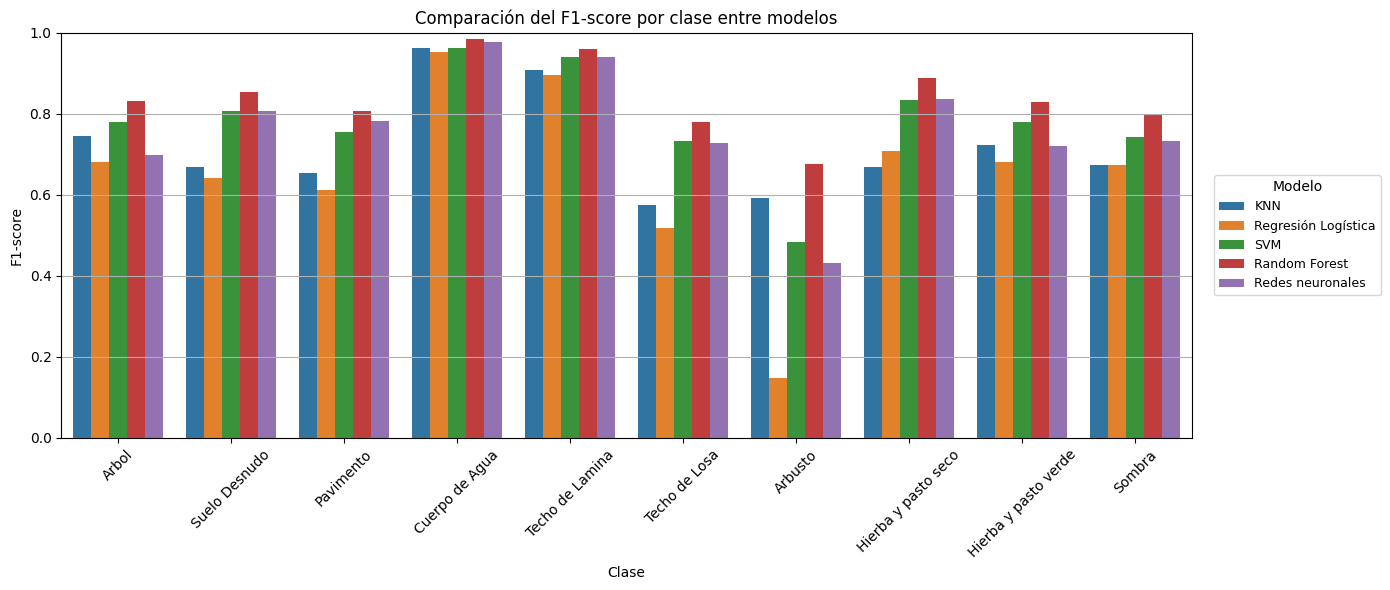

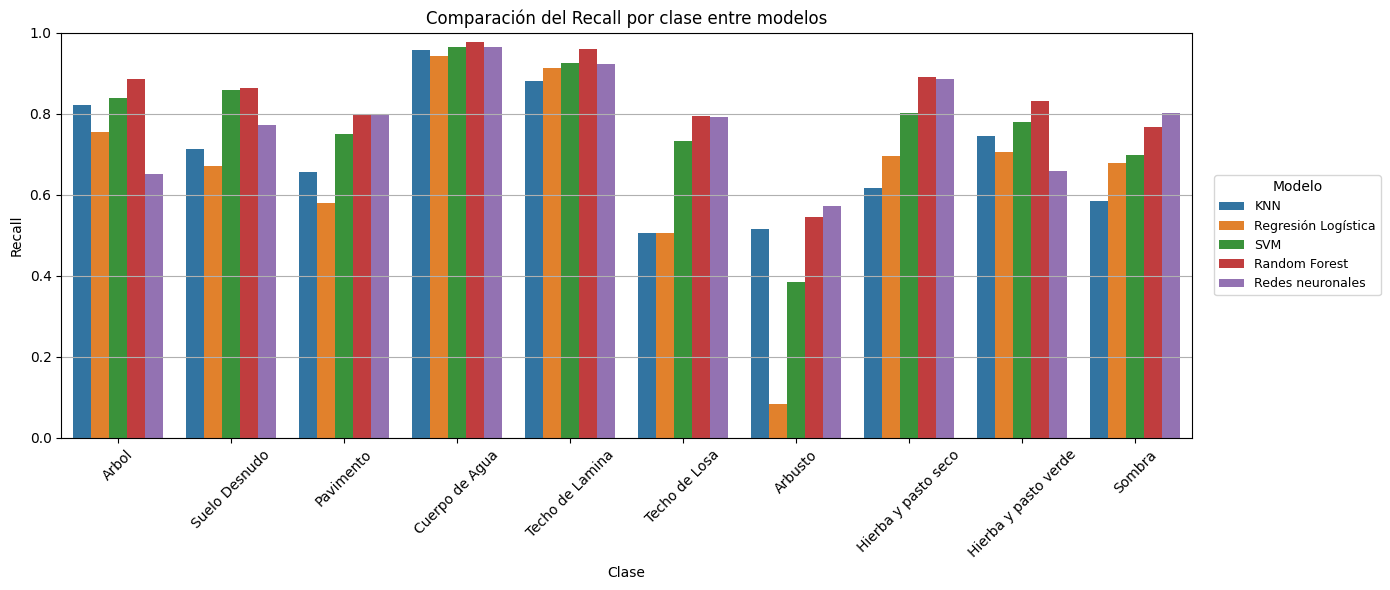

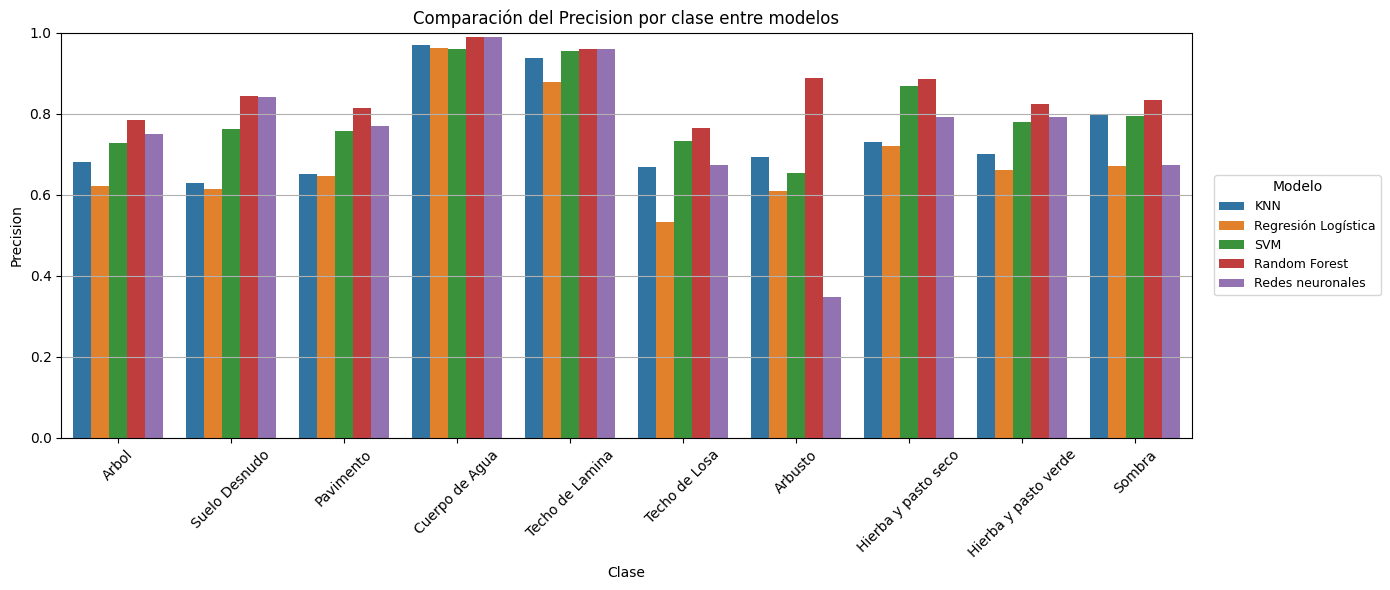

In [ ]:
# --------- Gráfica F1 por clase ----------
plt.figure(figsize=(14, 6))
sns.barplot(data=df_por_clase, x='Clase', y='f1-score', hue='Modelo')
plt.xticks(rotation=45)
plt.title("Comparación del F1-score por clase entre modelos")
plt.ylabel("F1-score")
plt.xlabel("Clase")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(
    title='Modelo',
    prop={'size': 9},
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0
)
plt.tight_layout()
plt.show()

# --------- Gráfica Recall por clase ----------

plt.figure(figsize=(14, 6))
sns.barplot(data=df_por_clase, x='Clase', y='recall', hue='Modelo')
plt.xticks(rotation=45)
plt.title("Comparación del Recall por clase entre modelos")
plt.ylabel("Recall")
plt.xlabel("Clase")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(
    title='Modelo',
    prop={'size': 9},
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0
)
plt.tight_layout()
plt.show()

# --------- Gráfica Recall por clase ----------

plt.figure(figsize=(14, 6))
sns.barplot(data=df_por_clase, x='Clase', y='precision', hue='Modelo')
plt.xticks(rotation=45)
plt.title("Comparación del Precision por clase entre modelos")
plt.ylabel("Precision")
plt.xlabel("Clase")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(
    title='Modelo',
    prop={'size': 9},
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0
)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<b> Resumen global por modelo </b>
</div>

In [ ]:
# --------- Resumen global por modelo ----------
resumen_rows = []
for nombre_modelo, y_pred in modelos:
    resumen_rows.append({
        "Modelo": nombre_modelo,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1_weighted": f1_score(y_test, y_pred, average='weighted', zero_division=0),
        "Balanced_Accuracy": balanced_accuracy_score(y_test, y_pred),
    })
df_resumen_global = pd.DataFrame(resumen_rows).sort_values("F1_weighted", ascending=False)
print("\nResumen global (ordenado por F1_weighted):")
display(df_resumen_global)

# (Opcional) Guardar resultados
df_por_clase.to_csv("comparacion_por_clase.csv", index=False)
df_resumen_global.to_csv("resumen_global_modelos.csv", index=False)
print("\nArchivos guardados: comparacion_por_clase.csv, resumen_global_modelos.csv")

<div class="alert alert-block alert-info">
<b> Comparacion de tiempos de  entrenamiento y predicción por modelo</b>
</div>

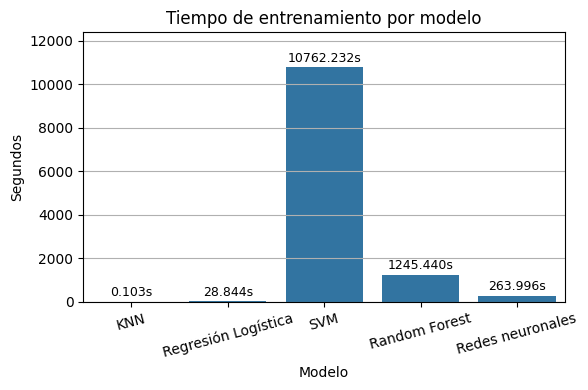

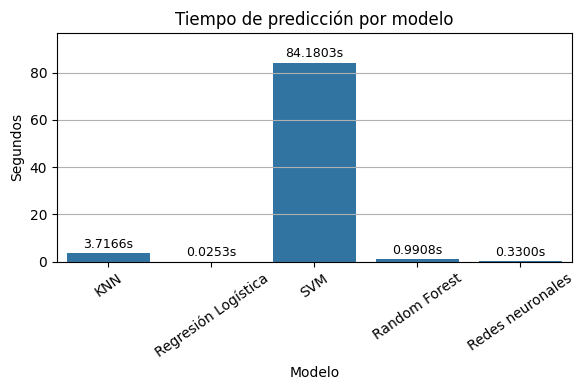

In [ ]:
# ============================================================
# COMPARACIÓN DE TIEMPOS de entrenamiento y predicción por modelo
# ============================================================

filas = [
    {"Modelo": "KNN",                "Entrenamiento_s": tiempo_entrenamiento_knn,            "Prediccion_s": tiempo_prediccion_knn},
    {"Modelo": "Regresión Logística","Entrenamiento_s": tiempo_entrenamiento_reg_log,        "Prediccion_s": tiempo_prediccion_reg_log},
    {"Modelo": "SVM",                "Entrenamiento_s": tiempo_entrenamiento_svm,            "Prediccion_s": tiempo_prediccion_svm},
    {"Modelo": "Random Forest",      "Entrenamiento_s": tiempo_entrenamiento_rf_version_2,   "Prediccion_s": tiempo_prediccion_rf_version_2},
    {"Modelo": "Redes neuronales",   "Entrenamiento_s": tiempo_entrenamiento_mlp,            "Prediccion_s": tiempo_prediccion_mlp},
]
df_tiempos = pd.DataFrame(filas)

def annotate_bars(ax, fmt="{:.3f}s", pad_frac=0.01):
    """Coloca el valor numérico arriba de cada barra del gráfico ax."""
    # margen superior para que quepan las etiquetas
    vals = [p.get_height() for p in ax.patches if p.get_height() is not None]
    if vals:
        ymax = max(vals)
        ax.set_ylim(0, ymax * 1.15)

    for p in ax.patches:
        h = p.get_height()
        if h is None or np.isnan(h):
            continue
        x = p.get_x() + p.get_width() / 2
        y = h + (ax.get_ylim()[1] * pad_frac)
        ax.text(x, y, fmt.format(h), ha="center", va="bottom", fontsize=9, rotation=0)

# --- Gráfica 1: Entrenamiento ---
plt.figure(figsize=(6, 4))
ax1 = sns.barplot(data=df_tiempos, x="Modelo", y="Entrenamiento_s")
plt.title("Tiempo de entrenamiento por modelo")
plt.ylabel("Segundos")
plt.xlabel("Modelo")
plt.xticks(rotation=15)
plt.grid(axis='y')
annotate_bars(ax1, fmt="{:.3f}s")
plt.tight_layout()
plt.show()

# --- Gráfica 2: Predicción ---
plt.figure(figsize=(6, 4))
ax2 = sns.barplot(data=df_tiempos, x="Modelo", y="Prediccion_s")
plt.title("Tiempo de predicción por modelo")
plt.ylabel("Segundos")
plt.xlabel("Modelo")
plt.xticks(rotation=35)
plt.grid(axis='y')
annotate_bars(ax2, fmt="{:.4f}s")  
plt.tight_layout()
plt.show()

